# Impact of model parameters on gas properties

In [1]:
%matplotlib widget

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Unit
from picasso import utils, nonthermal, polytrop

plt.rcParams.update(
    {
        "text.usetex": True,
        "text.latex.preamble": "\\usepackage{txfonts}",
        "font.family": "serif",
        "font.size": 12.0,
    }
)

Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!


Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2024-06-04 12:07:19.550696: W pjrt_plugin/src/mps_client.cc:563] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!


## Polytropic gas model with varying parameters

The polytropic gas model can be written as:

$$
\rho(\phi) = \rho_0 \theta^{\Gamma / (\Gamma - 1)}(\phi), \\[10pt]
P(\phi) = P_0 \theta^{1 / (\Gamma - 1)}(\phi),
$$
where $\phi$ is the halo's gravitational potential, and
$$
\theta(\phi) = 1 - \theta_0 (\phi - \phi_0),
$$

→ the model has four parameters: $(\rho_0, P_0)$ are the central value of gas density and pressure, $\Gamma$ is the gas adiabatic index, and $\theta_0$ is a shape parameter.
Let's vary each and look at the impact on gas density and pressure, for an NFW halo:

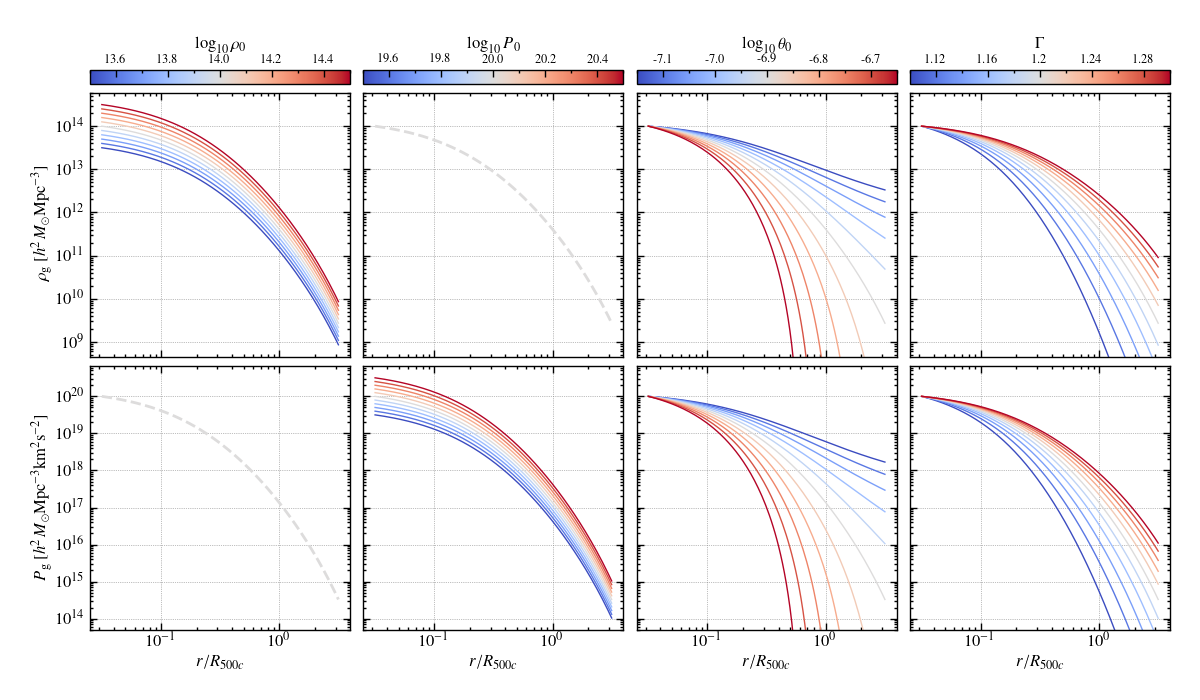

In [3]:
param_names = ["rho_0", "P_0", "theta_0", "Gamma"]
param_latex = ["$\\log_{10} \\rho_0$", "$\\log_{10} P_0$", "$\\log_{10} \\theta_0$", "$\\Gamma$"]
params_fix = {"rho_0": 14.0, "P_0": 20.0, "theta_0": -6.9, "Gamma": 1.2}
params_var = {
    "rho_0": np.linspace(13.5, 14.5, 11), 
    "P_0": np.linspace(19.5, 20.5, 11),
    "theta_0": np.linspace(-7.15, -6.65, 11),
    "Gamma": np.linspace(1.10, 1.30, 11)
}

M500c = 3.5e14  # h-1 Msun
c500c = 5.0
z = 0.0
cosmo = FlatLambdaCDM(70.0, 0.3)
nfw = utils.nfw.NFW(M500c / 0.7, c500c, "500c", 0.0, cosmo)
R500c = nfw.RDelta  # Mpc
r_R500c = np.logspace(-1.5, 0.5, 128)
phi = nfw.potential(r_R500c * R500c)
phi -= phi.min()

cmapname="coolwarm"
plt.close("all")
fig = plt.figure(figsize=(12, 7))
gs = mpl.gridspec.GridSpec(3, 4, height_ratios=[0.05, 0.975, 0.975])
cb_axs = [fig.add_subplot(gs[i]) for i in range(4)]
axs = np.array([[fig.add_subplot(gs[i+4]) for i in range(4)], [fig.add_subplot(gs[i+8]) for i in range(4)]])

par_vec_fix = params_fix.copy()
for p in ["rho_0", "P_0", "theta_0"]:
    par_vec_fix[p] = 10**par_vec_fix[p]
rho_fix, P_fix = polytrop.rho_P_g(phi, **par_vec_fix)
axs[0, 1].loglog(r_R500c, rho_fix, lw=2, ls="--", color=plt.colormaps[cmapname](0.5))
axs[1, 0].loglog(r_R500c, P_fix, lw=2, ls="--", color=plt.colormaps[cmapname](0.5))


for i_par_var, p_var in enumerate(param_names):
    norm = mpl.colors.Normalize(vmin=params_var[p_var].min(), vmax=params_var[p_var].max())
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=plt.colormaps[cmapname])
    cmap.set_array([])

    par_vecs = {p: np.ones(11) * params_fix[p] for p in param_names}
    par_vecs[p_var] = params_var[p_var]
    for p in ["rho_0", "P_0", "theta_0"]:
        par_vecs[p] = 10**par_vecs[p]
    for i_vec in range(11):
        rho, P = polytrop.rho_P_g(phi, **{p: par_vecs[p][i_vec] for p in param_names})
        if p_var != "P_0":
            axs[0, i_par_var].loglog(r_R500c, rho, color=cmap.to_rgba(params_var[p_var][i_vec]))
        if p_var != "rho_0":
            axs[1, i_par_var].loglog(r_R500c, P, color=cmap.to_rgba(params_var[p_var][i_vec]))

    cb = fig.colorbar(cmap, cax=cb_axs[i_par_var], orientation="horizontal", location="top")  #, ticks=params_var[p_var][::2])
    cb_axs[i_par_var].set_xticks(params_var[p_var], minor=True)
    cb_axs[i_par_var].set_xticks(params_var[p_var][1::2], np.round(params_var[p_var][1::2], 2), fontsize=9)
    cb.set_label(param_latex[i_par_var])

for ax in axs[0]:
    ax.set_ylim(*axs[0, 0].get_ylim())
    ax.set_xticklabels([])
for ax in axs[1]:
    ax.set_ylim(*axs[1, 1].get_ylim())
    ax.set_xlabel("$r / R_{500c}$")
for ax in axs[:, 1:].flatten():
    ax.set_yticklabels([])
for ax in axs.flatten():
    ax.xaxis.set_ticks_position("both")
    ax.yaxis.set_ticks_position("both")
    ax.grid(":", zorder=-5)
axs[0, 0].set_ylabel("$\\rho_{\\rm g} \\; [h^2 \\, M_\\odot {\\rm Mpc^{-3}}]$")
axs[1, 0].set_ylabel("$P_{\\rm g} \\; [h^2 \\, M_\\odot {\\rm Mpc^{-3} km^2 s^{-2}}]$")
fig.align_labels()
fig.subplots_adjust(left=0.075, right=0.975, top=0.90, bottom=0.1, hspace=0.05, wspace=0.05)


## Non-thermal pressure fraction with varying parameters

we write the fraction of non-thermal pressure as a power-law of radius, plus a constant plateau:

$$
f_{\rm nt}(r) = a_{\rm nt} + (b_{\rm nt} - a_{\rm nt}) \left(\frac{r}{r_{200m}}\right)^{c_{\rm nt}}
$$

→ three parameters: the central value of non-thermal pressure fraction $a_{\rm nt}$, the non-thermal pressure fraction at $r=r_{200m}$ $b_{\rm nt}$, and the power law evolution $c_{\rm nt}$.
let's vary each and look at the impact on the non-thermal pressure fraction:

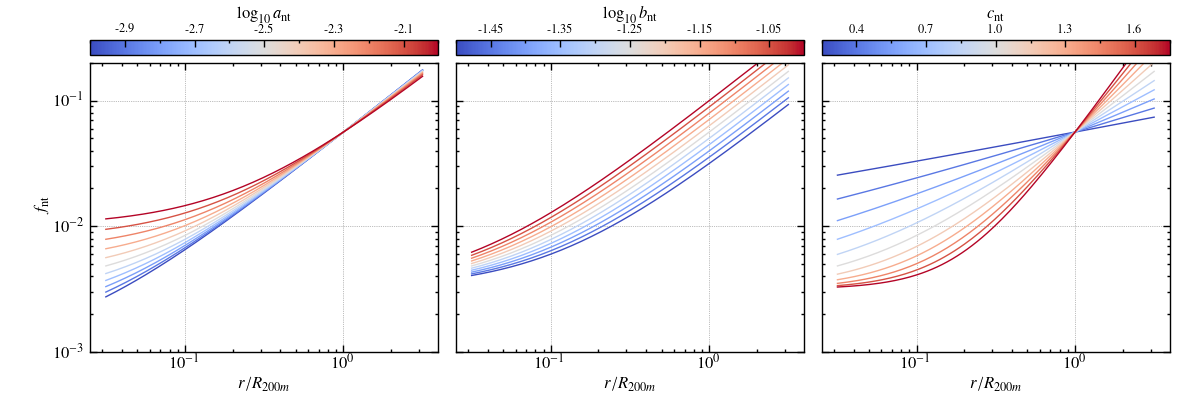

In [4]:
param_names = ["a", "b", "c"]
param_latex = ["$\\log_{10} a_{\\rm nt}$", "$\\log_{10} b_{\\rm nt}$", "$c_{\\rm nt}$"]
params_fix = {"a": -2.5, "b": -1.25, "c": 1.0}
params_var = {
    "a": np.linspace(-3.0, -2.0, 11),
    "b": np.linspace(-1.5, -1.0, 11),
    "c": np.linspace(0.25, 1.75, 11),
}

cmapname="coolwarm"
r_R500c = np.logspace(-1.5, 0.5, 128)
fig = plt.figure(figsize=(12, 4))
gs = mpl.gridspec.GridSpec(2, 3, height_ratios=[0.05, 0.95])
cb_axs = [fig.add_subplot(gs[i]) for i in range(3)]
axs = [fig.add_subplot(gs[i+3]) for i in range(3)]

par_vec_fix = params_fix.copy()
for p in "ab":
    par_vec_fix[p] = 10**par_vec_fix[p]

for i_par_var, p_var in enumerate(param_names):
    norm = mpl.colors.Normalize(vmin=params_var[p_var].min(), vmax=params_var[p_var].max())
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=plt.colormaps[cmapname])
    cmap.set_array([])

    par_vecs = {p: np.ones(11) * params_fix[p] for p in param_names}
    par_vecs[p_var] = params_var[p_var]
    for p in "ab":
        par_vecs[p] = 10**par_vecs[p]
    for i_vec in range(11):
        f_nt = nonthermal.f_nt_generic(r_R500c, **{p: par_vecs[p][i_vec] for p in param_names})
        axs[i_par_var].loglog(r_R500c, f_nt, color=cmap.to_rgba(params_var[p_var][i_vec]))

    cb = fig.colorbar(cmap, cax=cb_axs[i_par_var], orientation="horizontal", location="top")  #, ticks=params_var[p_var][::2])
    cb_axs[i_par_var].set_xticks(params_var[p_var], minor=True)
    cb_axs[i_par_var].set_xticks(params_var[p_var][1::2], np.round(params_var[p_var][1::2], 2), fontsize=9)
    cb.set_label(param_latex[i_par_var])

for ax in axs:
    ax.set_ylim(1e-3, 2e-1)
    ax.set_xlabel("$r / R_{200m}$")
    ax.xaxis.set_ticks_position("both")
    ax.yaxis.set_ticks_position("both")
    ax.grid(":", zorder=-5)
for ax in axs[1:]:
    ax.set_yticklabels([])
axs[0].set_ylabel("$f_{\\rm nt}$")
fig.align_labels()
fig.subplots_adjust(left=0.075, right=0.975, top=0.90, bottom=0.12, hspace=0.05, wspace=0.05)


# All together: Polytropic gas model and non-thermal pressure fraction with varying parameters

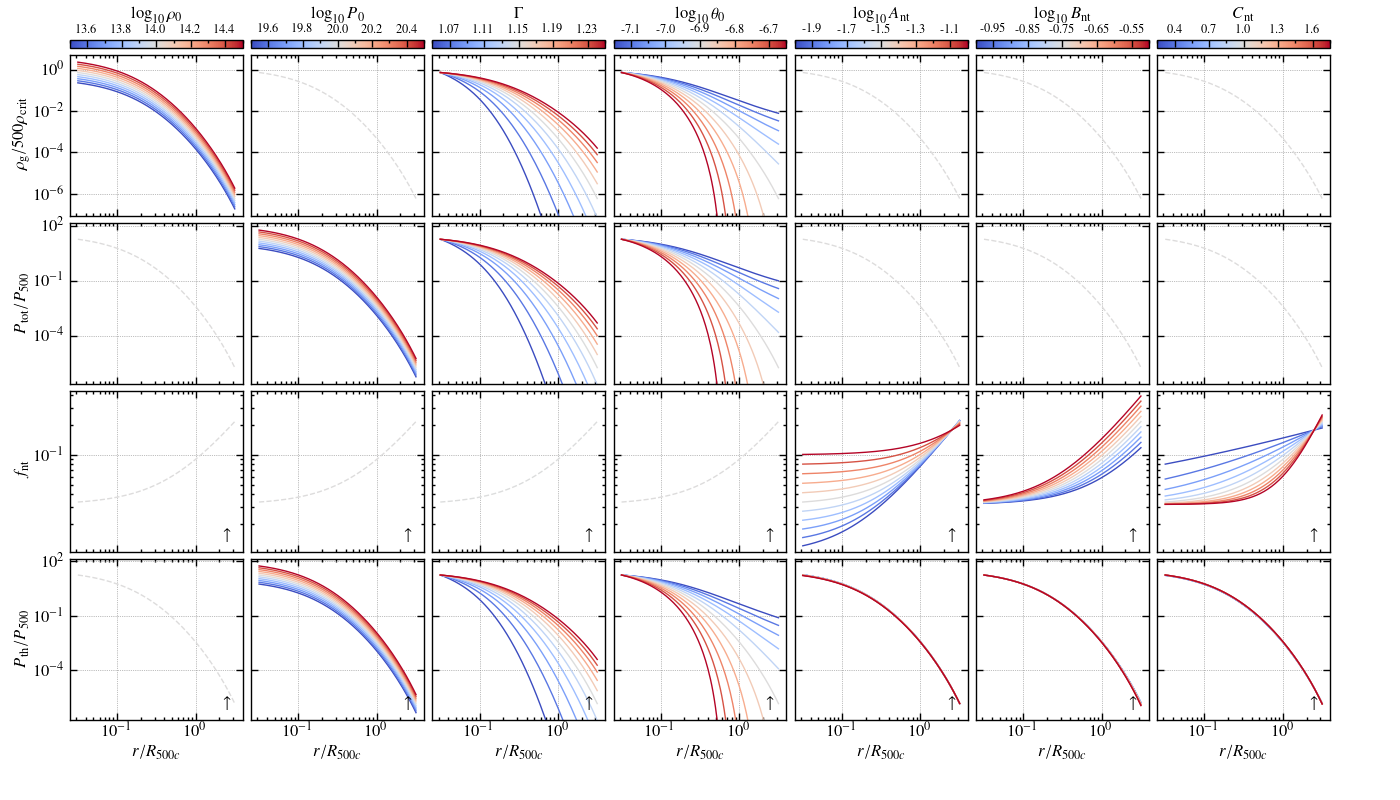

In [5]:
param_names = ["rho_0", "P_0", "Gamma", "theta_0", "a", "b", "c"]
param_latex = ["$\\log_{10} \\rho_0$", "$\\log_{10} P_0$", "$\\Gamma$", "$\\log_{10} \\theta_0$", "$\\log_{10} A_{\\rm nt}$", "$\\log_{10} B_{\\rm nt}$", "$C_{\\rm nt}$"]
params_fix = {
    "rho_0": 14.0,
    "P_0": 20.0,
    "Gamma": 1.15,
    "theta_0": -6.9,
    "a": -1.5,
    "b": -0.75,
    "c": 1.0
}
params_var = {
    "rho_0": np.linspace(13.5, 14.5, 11), 
    "P_0": np.linspace(19.5, 20.5, 11),
    "Gamma": np.linspace(1.05, 1.25, 11),
    "theta_0": np.linspace(-7.15, -6.65, 11),
    "a": np.linspace(-2.0, -1.0, 11),
    "b": np.linspace(-1.0, -0.5, 11),
    "c": np.linspace(0.25, 1.75, 11),
}
impacts = {
    "rho_0": [0],
    "P_0": [1, 3],
    "Gamma": [0, 1, 3],
    "theta_0": [0, 1, 3],
    "a": [2, 3],
    "b": [2, 3],
    "c": [2, 3],
}
n_p = len(param_names)

M500c = 3.5e14  # h-1 Msun
c500c = 5.0
z = 0.0
cosmo = FlatLambdaCDM(70.0, 0.3)
nfw = utils.nfw.NFW(M500c / 0.7, c500c, "500c", 0.0, cosmo)
R500c = nfw.RDelta  # Mpc
r_R500c = np.logspace(-1.5, 0.5, 128)
phi = nfw.potential(r_R500c * R500c)
phi -= phi.min()
rho500 = 500 * cosmo.critical_density(z).to("Msun/Mpc3").value / (cosmo.h ** 2)
p500 = (
    1.65e-3 * cosmo.efunc(z) ** (8/3)
    * (M500c / (3e14 * 0.7)) ** (2/3)
    * (cosmo.h / 0.7) ** 2
) * Unit("keV cm-3").to("Msun Mpc-3 km2 s-2")

cmapname="coolwarm"
fig = plt.figure(figsize=(14, 8))
gs = mpl.gridspec.GridSpec(5, n_p, height_ratios=[0.05, 0.975, 0.975, 0.975, 0.975])
cb_axs = [fig.add_subplot(gs[i]) for i in range(n_p)]
axs = np.array([
    [fig.add_subplot(gs[i+1*n_p]) for i in range(n_p)],
    [fig.add_subplot(gs[i+2*n_p]) for i in range(n_p)],
    [fig.add_subplot(gs[i+3*n_p]) for i in range(n_p)],
    [fig.add_subplot(gs[i+4*n_p]) for i in range(n_p)],
])

par_vec_fix = params_fix.copy()
for p in ["rho_0", "P_0", "theta_0", "a", "b"]:
    par_vec_fix[p] = 10**par_vec_fix[p]
# rho_fix, Ptot_fix = polytrop.rho_P_g(phi, **par_vec_fix)
# axs[0, 1].loglog(r_R500c, rho_fix, lw=2, ls="--", color=plt.colormaps[cmapname](0.5))
# axs[1, 0].loglog(r_R500c, Ptot_fix, lw=2, ls="--", color=plt.colormaps[cmapname](0.5))

def compute_props(rho_0, P_0, Gamma, theta_0, a, b, c):
    rho, P_tot = polytrop.rho_P_g(phi, rho_0, P_0, Gamma, theta_0)
    f_nt = nonthermal.f_nt_generic(r_R500c / 2.5, a, b, c)
    return rho / rho500, P_tot / p500, f_nt, (P_tot / p500) * (1 - f_nt)

fixed_props = compute_props(**par_vec_fix)

for i_par_var, p_var in enumerate(param_names):
    norm = mpl.colors.Normalize(vmin=params_var[p_var].min(), vmax=params_var[p_var].max())
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=plt.colormaps[cmapname])
    cmap.set_array([])

    par_vecs = {p: np.ones(11) * params_fix[p] for p in param_names}
    par_vecs[p_var] = params_var[p_var]
    for p in ["rho_0", "P_0", "theta_0", "a", "b"]:
        par_vecs[p] = 10**par_vecs[p]
    for i_vec in range(11):
        props = compute_props(**{p: par_vecs[p][i_vec] for p in param_names})
        for i_prop, (prop, ax) in enumerate(zip(props, axs[:, i_par_var])):
            if i_prop in impacts[p_var]:
                ax.loglog(r_R500c, prop, color=cmap.to_rgba(params_var[p_var][i_vec]))
            else:
                if i_vec == 0:
                    ax.loglog(r_R500c, fixed_props[i_prop], "--", color=cmap.to_rgba(params_fix[p_var]))

    cb = fig.colorbar(cmap, cax=cb_axs[i_par_var], orientation="horizontal", location="top")  #, ticks=params_var[p_var][::2])
    cb_axs[i_par_var].set_xticks(params_var[p_var], minor=True)
    cb_axs[i_par_var].set_xticks(params_var[p_var][1::2], np.round(params_var[p_var][1::2], 2), fontsize=9)
    cb.set_label(param_latex[i_par_var])

for i_row, row in enumerate(axs):
    col_ref = [0, 1, 4, 1]
    ylim = np.array([ax.get_ylim() for ax in row]).flatten()
    for ax in row:
        if i_row == 2:
            ax.set_ylim(ylim.min(), ylim.max())
        else:
            ax.set_ylim(*row[col_ref[i_row]].get_ylim())
        if i_row == 3:
            ax.set_xlabel("$r / R_{500c}$")
        else:
            ax.set_xticklabels([])
        if i_row in [2, 3]:
            ax.text(2.5, 0.1, "$\\uparrow$", fontsize=12, ha="center", va="center", transform=ax.get_xaxis_transform())
    for ax in row[1:]:
        ax.set_yticklabels([])
for ax in axs.flatten():
    ax.xaxis.set_ticks_position("both")
    ax.yaxis.set_ticks_position("both")
    ax.grid(":", zorder=-5)

axs[0, 0].set_ylabel("$\\rho_{\\rm g} / 500 \\rho_{\\rm crit}$")
axs[1, 0].set_ylabel("$P_{\\rm tot} / P_{500}$")
axs[2, 0].set_ylabel("$f_{\\rm nt}$")
axs[3, 0].set_ylabel("$P_{\\rm th} / P_{500}$")
fig.align_labels()
fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.1, hspace=0.05, wspace=0.05)
# fig.savefig("impact_model_params.pdf")
